# scrape the website with beautifulsoup


In [1]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
import html2text

# import my delayed_requests_get_with_cache function from ./lib
from lib.cached_request import delayed_requests_get_with_cache

c:\Git_Repos\BMW_RAG_support_bot\lib\cached_request.py:15: SyntaxWarning: invalid escape sequence '\_'
  cache_dir = "W:\_my_data\web_requests_cache"


In [2]:
def parse_date(date_str):
    # Define the time zone: GMT -4
    tz = pytz.timezone("Etc/GMT+4")

    # Check for 'Yesterday' and convert accordingly
    if "Yesterday" in date_str:
        # Replace 'Yesterday' with yesterday's date in the format MM-DD-YYYY
        yesterday = datetime.now(tz) - timedelta(days=1)
        date_str = yesterday.strftime("%m-%d-%Y") + date_str.split("Yesterday")[1]
    if "Today" in date_str:
        today = datetime.now(tz)
        date_str = today.strftime("%m-%d-%Y") + date_str.split("Today")[1]
    # Define the format for the datetime string
    # This format needs to match the structure of your input strings
    date_format = "%m-%d-%Y %I:%M %p"

    # Parse the datetime string into a datetime object
    # The datetime.strptime function does not directly support timezone-aware datetimes,
    # so initially, parse as naive datetime object
    dt_naive = datetime.strptime(date_str, date_format)

    # Make the datetime object timezone-aware
    dt_aware = tz.localize(dt_naive)

    return dt_aware

In [3]:
def parse_Thread_list_to_df(html_text):

    # Parse the HTML content of the page with BeautifulSoup
    soup = bs(html_text, "html.parser")

    # Use CSS selector to find all <li> elements where the id contains "thread_"
    li_elements = soup.select('li[id*="thread_"]')

    data = []

    for li in li_elements:
        thread_id = li["id"].replace("thread_", "")
        thread_title = li.find("a", class_="title").text.strip()

        started_by_element = li.find("div", class_="author").find("a", class_="username")
        started_by = started_by_element.text.strip() if started_by_element else "Unknown"

        posted_on = started_by_element["title"].split("on")[-1].strip()
        posted_on_date = parse_date(posted_on)

        replies_element = li.find(string=lambda text: "Replies" in text)
        replies = replies_element.parent.text.replace("Replies:", "").strip() if replies_element else "0"

        views_element = li.find(string=lambda text: "Views" in text)
        views = views_element.parent.text.replace("Views:", "").strip() if views_element else "0"

        link_to_thread = li.find("a", class_="title")["href"] if li.find("a", class_="title") else "No link"

        data.append(
            {
                "Thread_ID": thread_id,
                "Thread_Title": thread_title,
                "Started_by_username": started_by,
                "Posted_on_Date": posted_on_date,
                "Replies": replies,
                "Views": views,
                "Link_to_Thread": link_to_thread,
            }
        )

    df = pd.DataFrame(data)
    return df


# Send a GET request to the URL
html_text = delayed_requests_get_with_cache("https://www.bimmerforums.com/forum/forumdisplay.php?143-1975-1983-(E21)")

# Display the DataFrame
print(parse_Thread_list_to_df(html_text))

   Thread_ID                                       Thread_Title  \
0      81621                                       E21 Registry   
1     142866                      Post a Random Pix of Your E21   
2    1116784                    Post a Random Video of your E21   
3    1146050                            >> E21 FAQs and DIYs <<   
4    2484321  Master & Slave Cylinder Install Help - Clutch ...   
5    2484316                         m20b25 swap e21 323i trans   
6    2252568                   Very very very dim battery light   
7    2484218                     BMW E21 with a 335 ci Rover V8   
8    2484239                                   E21 light issues   
9    2484235                Early Style Ignition Switch Repair?   
10   2484098                           Engine rebuild questions   
11   2484205                     E-21 Fuel injector replacement   
12   2482942            Fuel pump relay availability - '79 E-21   
13   2483632             A/C Drive Belt Tension Pulley Options

In [4]:
# go through a whole subforum and full all the threads into a list
subsubforum_name = "143-1975-1983-(E21)"


def parse_subsubforum_to_df(subsubforum_name: str):
    subforum_url = "https://www.bimmerforums.com/forum/forumdisplay.php?" + subsubforum_name
    page_i_url = subforum_url + "/page" + str(1)
    page_i_text = delayed_requests_get_with_cache(page_i_url)

    # get the max number of pages, by reading from the element
    # div("threadpagenav").form.span("first_last").a["href"]
    # with bs4
    soup = bs(page_i_text, "html.parser")
    href_text = soup.find("div", class_="threadpagenav").find("form").find("span", class_="first_last").find("a")["href"]
    last_page = int(href_text.split("page")[-1].split("&")[0])
    print(f"{last_page = }")

    for i in range(1, last_page + 1):
        page_i_url = subforum_url + "/page" + str(i)
        page_i_text = delayed_requests_get_with_cache(page_i_url)
        threads_df = parse_Thread_list_to_df(page_i_text)

        if i == 1:
            # create the object
            df = threads_df
        else:
            # concat the result to the object
            df = pd.concat([df, threads_df])
        # add column with subforum name to all rows
        df["Subsubforum"] = subsubforum_name
    return df


df = parse_subsubforum_to_df(subsubforum_name)
print(df)

last_page = 15
   Thread_ID                                       Thread_Title  \
0      81621                                       E21 Registry   
1     142866                      Post a Random Pix of Your E21   
2    1116784                    Post a Random Video of your E21   
3    1146050                            >> E21 FAQs and DIYs <<   
4    2484321  Master & Slave Cylinder Install Help - Clutch ...   
..       ...                                                ...   
21   2469187                                     WTB: Black 323   
22   2473853    Blapunkt radio wiring/right speaker not working   
23   2473148  BMW E21 318 Solex DIDTA replacement with Weber...   
24   1611871                     Poly Steering Rack Bushing DIY   
0    2473797                             Relay for speed switch   

   Started_by_username            Posted_on_Date Replies      Views  \
0           BimmerDawg 2003-03-10 11:17:00-04:00     964  1,272,512   
1           blitzed310 2003-11-17 23:3

In [5]:
sum(df["Thread_Title"].duplicated(False))

4

In [6]:
df[df["Thread_Title"].duplicated(False)]

,Thread_ID,Thread_Title,Started_by_username,Posted_on_Date,Replies,Views,Link_to_Thread,Subsubforum
12,2483381,Annual Tune up done,320iAman,2024-02-03 23:54:00-04:00,2,408,showthread.php?2483381-Annual-Tune-up-done&s=a...,143-1975-1983-(E21)
4,2480360,Powerflex rear trailing arm adjustable bushing...,Qfbohc83,2023-10-17 00:51:00-04:00,0,290,showthread.php?2480360-Powerflex-rear-trailing...,143-1975-1983-(E21)
0,2478142,Powerflex rear trailing arm adjustable bushing...,Qfbohc83,2023-08-01 21:21:00-04:00,1,221,showthread.php?2478142-Powerflex-rear-trailing...,143-1975-1983-(E21)
2,2474481,Annual Tune up done,320iAman,2023-04-01 15:53:00-04:00,3,427,showthread.php?2474481-Annual-Tune-up-done&s=a...,143-1975-1983-(E21)


In [7]:
sub_sub_forums_of_3er_and_4er = [
    "143-1975-1983-(E21)",
    "20-1983-1991-(E30)",
    "14-1991-1999-(E36)",
    "15-1999-2006-(E46)",
    "189-2006-2012-(E90-E91-E92-E93)",
    "333-2012-2019-(F30-F32-F33-F34-F36)",
    "376-2018-(3-Series-sub-(G20-G22-G23-G24)"
]

In [15]:
# webscrape all the subsubforums for the 3er and 4er series Subforum

for i, subsubforum_name in enumerate(sub_sub_forums_of_3er_and_4er):
    if i == 0:
        # create the object
        df = parse_subsubforum_to_df(subsubforum_name)
    else:
        # concat the result to the object
        df = pd.concat([df, parse_subsubforum_to_df(subsubforum_name)], ignore_index=True)
# save the dataframe to a CSV file
file_name = "data/3er_and_4er_forum_threads.csv"

df.to_csv(file_name)
df_3er_and_4er_forum_threads = df.copy()

last_page = 15
last_page = 13
last_page = 35
last_page = 11
last_page = 11
last_page = 7
last_page = 2


In [9]:
def parse_thread_page_to_df(html_text):
    # Parse the HTML content of the page with BeautifulSoup
    soup = bs(html_text, "html.parser")

    # Use CSS selector to find all <li> elements where the id contains "thread_"
    li_elements = soup.select('li[id*="post_"]')
    posts_data = []
    for li in li_elements:
        post_id = li["id"].replace("post_", "")

        username = li.find("a", class_="username").text.strip()

        posted_on_element = li.find("span", class_="date")
        posted_on_date = parse_date(posted_on_element.text.replace(",\xa0", " "))

        # the content of a post is inside blockquote element with class="postcontent"
        content_blockquote = li.find("blockquote", class_="postcontent")
        # there is a feature on the forum, where you can reference another post in your post
        # To deduplicate content, I want to remove quotes of other posts
        quote = content_blockquote.find("div", class_="quote_container")
        if quote:
            quote.decompose()
        # Create an instance of the converter
        text_maker = html2text.HTML2Text()

        # Prevent wrapping of each line
        text_maker.wrap_links = False
        text_maker.skip_internal_links = True
        text_maker.inline_links = True
        text_maker.ignore_links = False
        text_maker.ignore_images = False
        text_maker.ignore_emphasis = False

        # converting a blockquote element to markdown results in a > in the beginning of all lines.
        # I do not want that, so I change the blockquote element to a p element
        t = str(content_blockquote)
        ts = t.split("\n")
        ts[0] = ts[0].replace("<blockquote", "<p")
        ts[-1] = ts[-1].replace("</blockquote>", "</p>")
        t = "\n".join(ts)
        # Convert the HTML to Markdown
        markdown_text = text_maker.handle(t)

        # print(f"{post_id = }")
        # print(f"{username = }")
        # print(f"{markdown_text}") # Print first line of the post
        # print("################################################################")

        posts_data.append(
            {"Post_ID": post_id, "Username": username, "Posted_on_Date": posted_on_date, "content": markdown_text}
        )

    df = pd.DataFrame(posts_data)
    return df


text = delayed_requests_get_with_cache(
    "https://www.bimmerforums.com/forum/showthread.php?2484316-m20b25-swap-e21-323i-trans"
)
print(parse_thread_page_to_df(text))

    Post_ID      Username            Posted_on_Date  \
0  30937439  coastalcrush 2024-03-06 13:10:00-04:00   
1  30937442     Ceaston85 2024-03-06 13:14:00-04:00   
2  30937450         82eye 2024-03-06 13:46:00-04:00   
3  30937575       hotdish 2024-03-06 22:56:00-04:00   
4  30937592  coastalcrush 2024-03-06 23:41:00-04:00   
5  30937650         82eye 2024-03-07 11:01:00-04:00   
6  30937678       hotdish 2024-03-07 13:46:00-04:00   

                                             content  
0  Will the e30 fly wheel and clutch pack work wi...  
1  Hmmm I wish I knew. I used the clutch and flyw...  
2  the e21 flywheel is a lightweight flywheel upg...  
3  I have an E30 m20b23 in my E21 323i with the o...  
4  The m20b25 I’m swapping in came with a brand n...  
5  TOB is where you are going to have issues. the...  
6  The 323i transmissions do not use a specific T...  


In [13]:
def parse_thread_to_df(url: str):
    # there may be several pages to this thread, so first I check how many pages there are
    # then i go through them in a loop and add them to the dataframe

    page_i_text = delayed_requests_get_with_cache(url)
    # with bs4
    soup = bs(page_i_text, "html.parser")
    pagination_form_element = soup.find("div", class_="pagination_top").find("form", class_="pagination")
    last_page_number = 1
    if pagination_form_element:
        # if the element exists, then there are multiple pages
        href_text = pagination_form_element.find("span", class_="first_last").find("a")["href"]
        last_page_number = int(href_text.split("page")[-1].split("&")[0])

    for i in range(1, last_page_number + 1):
        page_i_url = url + "/page" + str(i)
        page_i_text = delayed_requests_get_with_cache(page_i_url)
        df_page = parse_thread_page_to_df(page_i_text)

        if i == 1:
            # create the object
            df = df_page
        else:
            # concat the result to the object
            df = pd.concat([df, df_page], ignore_index=True)
    df["Thread_ID"] = url.split("showthread.php?")[-1].split("-")[0]
    return df


df = parse_thread_to_df("https://www.bimmerforums.com/forum/showthread.php?2471968-%9183-E21-320is-New-to-the-forum!")
df

,Post_ID,Username,Posted_on_Date,content,Thread_ID
0,30859428,n7slc,2023-01-22 01:59:00-04:00,Hey all! \n \nMy name is Dan and Im a longt...,2471968
1,30859508,Rushfan1,2023-01-22 14:12:00-04:00,I can't offer any technical help but I would l...,2471968
2,30859530,mjweimer,2023-01-22 15:26:00-04:00,Sounds like a fun project and welcome to the f...,2471968
3,30859732,320iAman,2023-01-23 13:32:00-04:00,Welcome to the E21 Forum. As too the fuel pres...,2471968
4,30860293,n7slc,2023-01-25 11:04:00-04:00,Thanks guys for the warm welcome! I've been a ...,2471968
5,30860347,mjweimer,2023-01-25 14:33:00-04:00,Hey Dan - on my car those two ports are capped...,2471968
6,30860348,320iAman,2023-01-25 14:42:00-04:00,Sounds good. \n \n \nRandy\n\n,2471968
7,30860354,n7slc,2023-01-25 15:06:00-04:00,"That's great, thanks!\n\n",2471968
8,30861108,n7slc,2023-01-28 18:50:00-04:00,"So, I finally got the new fuel pump, accumulat...",2471968
9,30861130,320iAman,2023-01-28 20:32:00-04:00,See Faq's Fuel Distributor Rebuild and Links i...,2471968


In [17]:
df_3er_and_4er_forum_threads

,Thread_ID,Thread_Title,Started_by_username,Posted_on_Date,Replies,Views,Link_to_Thread,Subsubforum
0,81621,E21 Registry,BimmerDawg,2003-03-10 11:17:00-04:00,964,"1,272,512",showthread.php?81621-E21-Registry&s=a695290568...,143-1975-1983-(E21)
1,142866,Post a Random Pix of Your E21,blitzed310,2003-11-17 23:38:00-04:00,"6,784","3,027,447",showthread.php?142866-Post-a-Random-Pix-of-You...,143-1975-1983-(E21)
2,1116784,Post a Random Video of your E21,Rickysbmw320i,2008-11-10 16:09:00-04:00,304,"566,190",showthread.php?1116784-Post-a-Random-Video-of-...,143-1975-1983-(E21)
3,1146050,>> E21 FAQs and DIYs <<,jrcook320,2008-12-29 03:52:00-04:00,16,"300,117",showthread.php?1146050-gt-gt-E21-FAQs-and-DIYs...,143-1975-1983-(E21)
4,2484321,Master & Slave Cylinder Install Help - Clutch ...,yacob555,2024-03-06 16:34:00-04:00,4,113,showthread.php?2484321-Master-amp-Slave-Cylind...,143-1975-1983-(E21)
...,...,...,...,...,...,...,...,...
2286,2476491,330 xdr a - g20,TOMMY4268,2023-06-06 14:52:00-04:00,0,820,showthread.php?2476491-330-xdr-a-g20&s=a695290...,376-2018-(3-Series-sub-(G20-G22-G23-G24)
2287,2472872,Door lock on door not working,GoneTribal,2023-02-18 14:40:00-04:00,1,"1,351",showthread.php?2472872-Door-lock-on-door-not-w...,376-2018-(3-Series-sub-(G20-G22-G23-G24)
2288,2474604,Acura to BMW 3 Series!,JLH81,2023-04-06 15:37:00-04:00,2,"1,515",showthread.php?2474604-Acura-to-BMW-3-Series!&...,376-2018-(3-Series-sub-(G20-G22-G23-G24)
2289,2474473,OTA via myBmw: wifi connection required,tomvh,2023-04-01 08:04:00-04:00,1,916,showthread.php?2474473-OTA-via-myBmw-wifi-conn...,376-2018-(3-Series-sub-(G20-G22-G23-G24)


In [21]:
# go through the list of all threads and get the content of the posts
base_url = "https://www.bimmerforums.com/forum/"
for index, row in df_3er_and_4er_forum_threads.iterrows():
    thread_url = base_url + row["Link_to_Thread"]
    df_thread = parse_thread_to_df(thread_url)

    if index == 0:
        df = df_thread
    else:
        df = pd.concat([df, df_thread], ignore_index=True)

df_3er_and_4er_forum_posts = df.copy()
file_name = "data/3er_and_4er_forum_posts.csv"
df.to_csv(file_name, errors="surrogatepass")

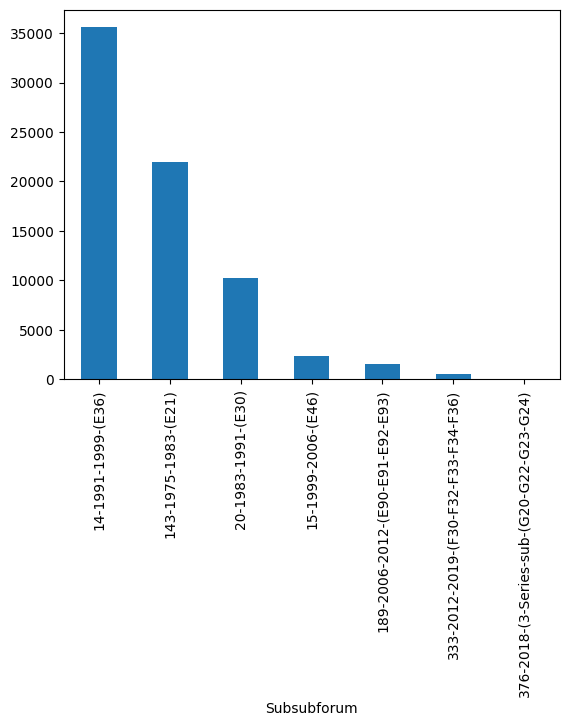

In [41]:
# extend the dataframe with the subsubforum information
# I want to add another column with the subsubforum name to all rows
# I can match the data by the Thread_ID, which is in both dataframes

df_3er_and_4er_forum_posts_extended = df_3er_and_4er_forum_posts.merge(
    df_3er_and_4er_forum_threads[["Thread_ID", "Subsubforum"]], on="Thread_ID"
)
df_3er_and_4er_forum_posts_extended

# I want to check how many posts there are for each subsubforum
df_3er_and_4er_forum_posts_extended["Subsubforum"].value_counts()

df_3er_and_4er_forum_posts_extended["Subsubforum"].value_counts().plot(kind="bar")
file_name = "data/3er_and_4er_forum_posts.csv"
df_3er_and_4er_forum_posts_extended.to_csv(file_name, errors="surrogatepass")

In [45]:
df_3er_and_4er_forum_posts_extended.to_pickle("data/3er_and_4er_forum_posts_extended.pkl")
df_3er_and_4er_forum_threads.to_pickle("data/3er_and_4er_forum_threads.pkl")

In [43]:
def attribute_description(data):
    longestColumnName = len(max(np.array(data.columns), key=len))
    length_first_col = longestColumnName + 1
    print("| " + "Feature".ljust(length_first_col) + "| Data Type |")
    print("|" + "-" * (length_first_col + 1) + "|-----------|")
    for col in data.columns:
        description = ""
        col_dropna = data[col].dropna()
        if col_dropna.empty:
            description += " -- col is empty --"
        else:
            example = col_dropna.sample(1).values[0]
            # if it is a string
            if type(example) == str:
                description = "str "
                if len(col_dropna.unique()) < 10:
                    description += "{"
                    description += "; ".join([f'"{name}"' for name in col_dropna.unique()])
                    description += "}"
                else:
                    description += '[ example: "' + example + '" ]'
            # if it is a typical dummy variable int32 with less then 10 entries
            elif (type(example) == np.int32) and (len(col_dropna.unique()) < 10):
                description += "dummy int32 {"
                description += "; ".join([f"{name}" for name in sorted(col_dropna.unique())])
                description += "}"
            # if it is a numpy type
            elif "numpy" in str(type(example)):
                kind = example.dtype.kind
                if kind == "i" or kind == "u" or kind == "f" or kind == "c":  # if it is a number
                    description = f"{('numpy.'+str(example.dtype)).ljust(10)} [ {col_dropna.min()}; {col_dropna.max()} ]"
                else:
                    description = type(example)
            else:
                description = type(example)
        print("| " + col.ljust(length_first_col) + f"| {description} |")


attribute_description(df_3er_and_4er_forum_posts_extended)

| Feature        | Data Type |
|----------------|-----------|
| Post_ID        | str [ example: "7987350" ] |
| Username       | str [ example: "Steve547i" ] |
| Posted_on_Date | <class 'numpy.datetime64'> |
| content        | str [ example: "Well I didn't "do" anything yet but I did manage to source + win the auction for a powered rear vent window kit from Germany for my 99 M3 coupe ![](/images/smilies//smile.gif) Every original part needed, even dash with switches, for $180 (I love eBay Germany...). Will be part of a massive interior/exterior rebuild to install the powered ZKW's, rear sunshade and rear fog lights. 

" ] |
| Thread_ID      | str [ example: "1241671" ] |
| Subsubforum    | str {"143-1975-1983-(E21)"; "20-1983-1991-(E30)"; "14-1991-1999-(E36)"; "15-1999-2006-(E46)"; "189-2006-2012-(E90-E91-E92-E93)"; "333-2012-2019-(F30-F32-F33-F34-F36)"; "376-2018-(3-Series-sub-(G20-G22-G23-G24)"} |


# try to use RSS

In [44]:
import feedparser

# Replace this with the RSS feed URL you're interested in
rss_url = "https://www.bimmerforums.com/feed/"

# Parse the RSS feed
feed = feedparser.parse(rss_url)

# Check if the feed was successfully parsed
if feed.bozo == 0:
    # Loop through each post
    for post in feed.entries:
        # Print the title and link of each post
        print(post.title)
        print(post.link)
        print("---")
else:
    print("Could not parse the feed. Please check the RSS feed URL.")

6 Long-Term Maintenance Practices All BMW Owners Should Know
https://www.bimmerforums.com/2024/01/6-long-term-maintenance-practices-all-bmw-owners-should-know/
---
7 Clever Ways to Enhance Your BMW’s Security
https://www.bimmerforums.com/2023/11/7-clever-ways-to-enhance-your-bmws-security/
---
Drive Down BMW Maintenance Costs With These 7 Smart Strategies
https://www.bimmerforums.com/2023/09/drive-down-bmw-maintenance-costs-with-these-7-smart-strategies/
---


In [ ]:
post

{'title': 'Drive Down BMW Maintenance Costs With These 7 Smart Strategies',
 'title_detail': {'type': 'text/plain',
  'language': None,
  'base': 'https://www.bimmerforums.com/feed/',
  'value': 'Drive Down BMW Maintenance Costs With These 7 Smart Strategies'},
 'links': [{'rel': 'alternate',
   'type': 'text/html',
   'href': 'https://www.bimmerforums.com/2023/09/drive-down-bmw-maintenance-costs-with-these-7-smart-strategies/'}],
 'link': 'https://www.bimmerforums.com/2023/09/drive-down-bmw-maintenance-costs-with-these-7-smart-strategies/',
 'authors': [{'name': 'Martin Banks'}],
 'author': 'Martin Banks',
 'author_detail': {'name': 'Martin Banks'},
 'published': 'Tue, 12 Sep 2023 14:45:16 +0000',
 'published_parsed': time.struct_time(tm_year=2023, tm_mon=9, tm_mday=12, tm_hour=14, tm_min=45, tm_sec=16, tm_wday=1, tm_yday=255, tm_isdst=0),
 'tags': [{'term': 'Car Care', 'scheme': None, 'label': None}],
 'id': 'https://www.bimmerforums.com/?p=3917',
 'guidislink': False,
 'summary': '<